<a href="https://colab.research.google.com/github/hannaofficial/204M_Llama2_build_from_scratch/blob/main/llama2_built_from_scratch_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How did I write this code

I take GPT3 code as reference that I learn from adrej karpathy and then I modified the code based on llama research paper llama 1,2,3

Only difference bet llama 2 and 3 is scaling(50x more parameter than llama2) but all the fundamental unit are moreover same that's why I write llama2 not 3.

Even my model is tiny.

What are the diiference in LLama wrt gpt3

* RMS normalization compare to layernorm
* Rope with respected to static position embedding with training parameter
* Swiglu wrt Gelu
* implementing xformers instead of Flash attention it is same but more efficient then direct implementation and also use the latest top attention
* custom linear implemention and save checkpoint for ram efficiency

In [ ]:
!pip install triton    #xformers is install due to implement efficient flash attention develop by meta
!pip install xformers
!pip install tiktoken
!pip install xformers --upgrade

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass
import inspect
import os
%matplotlib inline

device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
print(f'{device} is available')


#----------------------------------------------------------

from torch.distributed import init_process_group, destroy_process_group

#set up DDP (distributed data parrallel)
#trochrun command set the env varable RANK, LOCALRANK and WORLD SIZE
ddp = int(os.environ.get('RANK',-1)) != -1
if ddp:
  assert torch.cuda.is_available(), 'for now i think we need cuda'
  init_process_group(backend='nccl')
  ddp_rank = int(os.environ['RANK'])  #identification of each gpu
  ddp_local_rank = int(os.environ['LOCAL_RANK'])  #rank of the gpu on single node
  ddp_world_size = int(os.environ['WORLD_SIZE'])  #total num of processes/gpu running
  device = f'cuda:{ddp_local_rank}'
  torch.cuda.set_device(device)
  master_process = ddp_rank == 0
else:
  #vanilla, non-DDP run
  ddp_rank = 0
  ddp_local_rank = 0
  ddp_world_size = 1
  master_process = True
  #attempt to autodetect device
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda"
  elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
  print(f"using device: {device}")

#------------------------------

#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

cuda is available
using device: cuda


# **CUSTOM LINEAR LAYER CODE FOR EFFICIENCY FROM LLAMA2 PAPER**

---



In [ ]:
#custom linear for optimized forward and backward call
class Custom_autograd_Linear(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input, weight, bias=None):
    ctx.save_for_backward(input, weight, bias)
    output = input @ weight.t()
    if bias is not None:
      output += bias
    return output

  @staticmethod
  def backward(ctx, grad_output):
    input, weight, bias = ctx.saved_tensors
    #print("Input shape:", input.shape if input is not None else "None",  "Weight shape:", weight.shape if weight is not None else "None", "grad_output shape:", grad_output.shape if grad_output is not None else "None",
          #"Bias shape:", bias.shape if bias is not None else "None")
    grad_input = grad_weight = grad_bias = None
    if ctx.needs_input_grad[0]:
      grad_input = grad_output @ weight  #dl/dx  loss wrt input
    if ctx.needs_input_grad[1]:
      #grad_weight = grad_output.transpose(0, 1) @ input #dl/dw   B T C
      grad_weight = torch.einsum('...o,...i->oi', grad_output, input)
    if bias is not None and ctx.needs_input_grad[2]:
      grad_bias = grad_output.sum(dim=[0, 1])  #dl/db
    return grad_input, grad_weight, grad_bias

class Optimize_linear(torch.nn.Module):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))
    if bias:
      self.bias = torch.nn.Parameter(torch.randn(out_features))

  def forward(self, x):
    return Custom_autograd_Linear.apply(x, self.weight, self.bias if hasattr(self, 'bias') else None)

In [ ]:
#it is important for efficient attention build by meta get recommendation from llama paper
import xformers.ops as xops
print(xops)

<module 'xformers.ops' from '/usr/local/lib/python3.11/dist-packages/xformers/ops/__init__.py'>


# **FUNCTION OF FUNDAMENTAL UNIT OF MODEL 🧩**

---



In [ ]:
import inspect
@dataclass
class GPTConfig:
  block_size: int =  1024
  vocab_size: int = 50257
  n_layer: int = 12
  n_head: int = 12
  n_embd: int = 768

class RMSNorm(torch.nn.Module):
  def __init__(self,  dim, eps=1e-5):
    super().__init__()
    self.dim = dim
    self.gamma = torch.nn.Parameter(torch.ones(dim,))
    self.eps = eps
  def forward(self, x):
    return x*torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)*self.gamma
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
class RoPE(torch.nn.Module):
    def __init__(self, dim, base=10000, max_length=2048):
      super().__init__()
      assert dim % 2 == 0, "Dimension must be divisible by 2"

      self.dim = dim
      self.base = base
      self.max_length = max_length

      theta = 1.0/base**(torch.arange(0, dim, 2)[: (self.dim // 2)].float()/dim)  #[: (self.dim // 2)] for security if it exceed more than self.dim//2 code taken from pytorch implementation of rope
      self.register_buffer('theta', theta)

      m = torch.arange(max_length, dtype=torch.float)
      self.register_buffer('m',m)

      #mtheta
      mtheta = torch.outer(m, theta)
      self.register_buffer('cos_val', torch.cos(mtheta))  #real part
      self.register_buffer('sin_val', torch.sin(mtheta))  #imag part

      #now I will combine cos sin such that at last dim it would look like [cos_val, sin_val] this code is good for intuition
      cos_sin = torch.stack([self.cos_val, self.sin_val], dim=-1)
      self.register_buffer('cos_sin', cos_sin)  #dim = [seq_len, dim/2,2]

    def rotate_90(self, x):  #this rotate 90 resemble i*x in complex plane (i resemble iota)

      #based on maths if the matrix is [x1, x2, x3, x4] then rotated matrix will be [-x2,x1, -x4,x3]
      #this implementation i same as the RoPE implementation in hugging face
      x1 = x[...,0::2]  #for taking even position
      x2 = x[...,1::2] #for taking odd position
      return torch.stack((-x2, x1), dim=-1).reshape_as(x)

    def apply_rotatory(self, x, start_idx=0):
      seq_len = x.size(2)

      """
      Process2: with complex equation = rotated_x = cos(theta)*x + i*x*sin(theta)

      cos_val = torch.stack((cos_val, cos_val), dim=-1).reshape(x.shape)
      sin_val = torch.stack((sin_val, -sin_val), dim=-1).reshape(x.shape)
      rotated_x = cos_val*x + self.rotate_90(x)*sin_val
      return rotated_x

      """
      x_reshaped = x.reshape(*x.shape[:-1], -1, 2)
      """
      why we are doing this is more intuitive in coming code
      we are making last dim as (dim/2, 2) ex: [x1,x2,x3,x4] as [[x1,x2],[x3,x4]] in last dim there will be one real part and one imaginary part
      complex num: (a +ib) it will look like [a,b]
      """
      x1 = x_reshaped[...,0] #this will take all the real part
      x2 = x_reshaped[...,1] #... means all the dim same but from last dim only 1 index

      original_x1 = x1.clone()


      rope_cos_sin = self.cos_sin[start_idx: start_idx+seq_len].unsqueeze(0).unsqueeze(1)  #--> [seq_len, dim/2,2] ---> [1, 1,seq_len, dim/2,2]
      cos_val = rope_cos_sin[...,0]
      sin_val = rope_cos_sin[...,1]

      """
      #other methos for cos and sin value but I think above one is more intuitive
      cos_val = self.cos_val[start_idx: start_idx+seq_len].unsqueeze(0).unsqueeze(1).expand(x1.shape[0], x1.shape[1], -1, -1)
      sin_val = self.sin_val[start_idx: start_idx+seq_len].unsqueeze(0).unsqueeze(1).expand(x1.shape[0], x1.shape[1], -1, -1)
      # without expand it would look like  [1, 1, seq_len, dim//2]  but we are not using expand that gonna automatically broadcast and make the dim as [B,nh,seq_len, dim//2]

      """

      ## (a + bi)(cos θ + i sin θ) = (a cos θ - b sin θ) + (a sin θ + b cos θ)i  this is actual multiplication
      x1 = x1*cos_val - x2*sin_val    #real part
      x2 = original_x1*sin_val + x2*cos_val  #imaginary part

      rotated_x = torch.stack([x1, x2], dim=-1).reshape(*x.shape)  #stack help to join real and img part it will join first index from x1 with first index from x2 to form again [x1,x2]

      return rotated_x

    def forward(self, q, k):
      q = self.apply_rotatory(q)
      k = self.apply_rotatory(k)
      return q,k

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------

class swiGLU(torch.nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim
    self.linear = torch.nn.Linear(dim, 2*dim)

  def forward(self, x):
    input, gate = self.linear(x).chunk(2, dim=-1)  #diving a, 2b ---> a,b  as input and gate should  be independent and there parameter should also be different therefore it divide into 2
    return input*torch.sigmoid(gate)

class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.ln_1 = RMSNorm(config.n_embd)
    self.ln_2 = RMSNorm(config.n_embd)
    self.attn = CasualAttention(config)
    self.mlp = MLP(config)

  def forward(self, x):
    x = x + self.attn(self.ln_1(x))
    x = x + self.mlp(self.ln_2(x))
    return x

#changing from nn.Linear to optimize_linear that i define

class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.llama_config = int((2/3)*4*config.n_embd) #we use  this because instead of two matrics we gonna use three matrices in GLU variant FFN to make the parameter same as basemodel ref: SwiGlu paper 3.1
    self.c_fc = Optimize_linear(config.n_embd, self.llama_config)
    self.gelu = swiGLU(self.llama_config)  #nn.GELU(approximate='tanh') is replace
    self.c_proj = Optimize_linear( self.llama_config, config.n_embd)
    self.c_proj.SCALE_STD = 1.0

  def forward(self, x):
    x = self.gelu(self.c_fc(x))
    x = self.c_proj(x)
    return x

import xformers
#xformers.set_log_level("DEBUG")
#import logging
#logging.basicConfig(level=logging.DEBUG)   #to check whether xformer is using flashattention or not

class CasualAttention(nn.Module):  #MultiHeadAttention
  def __init__(self, config):
    super().__init__()
    self. c_attn = Optimize_linear(config.n_embd, 3*config.n_embd)  #general nn.Linear is replace for efficiency
    self.c_proj = Optimize_linear(config.n_embd, config.n_embd)
    self.n_head = config.n_head
    self.n_embd = config.n_embd
    self.c_proj.SCALE_STD = 1.0
    #self.register_buffer('bias', torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    # Add RoPE
    self.rope = RoPE(dim=config.n_embd //config.n_head, max_length=config.block_size)
    self.register_buffer('attn_mask', xops.LowerTriangularMask().to(device))

  def forward(self, x):
    B, T,C  = x.size()
    q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
    q = q.view(B, T, self.n_head, C//self.n_head).transpose(1, 2) #(B,T,C) ---> (B, T, nh, nc) --> (B, nh, T, nc)
    k = k.view(B, T, self.n_head, C//self.n_head).transpose(1, 2)
    v = v.view(B, T, self.n_head, C//self.n_head).transpose(1, 2)

    q, k = self.rope(q, k)

    self.attn_mask = self.attn_mask.to(x.device)

    #y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
    y = xops.memory_efficient_attention(q, k, v, attn_bias=self.attn_mask)
    y = y.transpose(1,2).contiguous().view(B, T, C) # B nh T nc --> B T nc
    #linear transformation for learning and compiling concat head in more correct order think like above y is concat opinion and after self.c_proj is like commeti that will take the comibined opinion and choose his opinion
    #this is actually learned weight for better compiling learning
    y = self.c_proj(y)
    return y


#MQA
#this will mostly used at the last of pretaining and then in inference for fast , there is problem it reduce quality by a lot
class MultiQueryAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.n_head = config.n_head
    self.nc = self.n_embd // config.n_head

    self.q_proj = Optimize_linear(config.n_embd, config.n_embd)
    self.kv_proj = Optimize_linear(config.n_embd, 2*self.nc)   #this code reduce the parameters compare to first one instead of n_embd we use self.nc
    self.c_proj = Optimize_linear(config.n_embd, config.n_embd)


    self.n_embd = config.n_embd
    self.c_proj.SCALE_STD = 1.0

    self.rope = RoPE(dim=config.n_embd //config.n_head, max_length=config.block_size)
    self.register_buffer('attn_mask', xops.LowerTriangularMask().to(device))

  def forward(self, x):
    B, T,C  = x.size()

    q = self.q_proj(x)
    k, v = self.kv_proj(x).split(self.nc, dim=2)

    q = q.view(B, T, self.n_head, self.nc).transpose(1, 2) #(B,T,C) ---> (B, T, nh, nc) --> (B, nh, T, nc)
    k = k.view(B, T, 1, self.nc).transpose(1, 2)
    v = v.view(B, T, 1, self.nc).transpose(1, 2)

    q, k = self.rope(q, k)
    self.attn_mask = self.attn_mask.to(x.device)
    y = xops.memory_efficient_attention(q, k, v, attn_bias=self.attn_mask)
    y = y.transpose(1,2).contiguous().view(B, T, C) # B nh T nc --> B T nc
    y = self.c_proj(y)
    return y


#MGA paper: GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints , this is actually generalized query attention and bet mha, mqa
class GroupQueryAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.num_query_in_groups = 2
    self.n_head = config.n_head
    self.nc = self.n_embd // config.n_head
    self.n_kv_heads = self.n_head // self.num_query_in_groups

    self.q_proj = Optimize_linear(config.n_embd, config.n_embd)
    self.kv_proj = Optimize_linear(config.n_embd, self.n_kv_heads*2*self.nc)  #initially there was 1 kv_heads here it depends on the number of query in the group

    self.n_embd = config.n_embd
    self.c_proj = Optimize_linear(config.n_embd, config.n_embd)
    self.c_proj.SCALE_STD = 1.0

    self.rope = RoPE(dim=config.n_embd //config.n_head, max_length=config.block_size)
    self.register_buffer('attn_mask', xops.LowerTriangularMask().to(device))

  def forward(self, x):
    B, T, C = x.size()

    q = self.q_proj(x)
    k, v = self.kv_proj(x).chunk(2, dim=-1)

    q = q.view(B, T, self.n_head, self.nc).transpose(1, 2) #(B,T,C) ---> (B, T, nh, nc) --> (B, nh, T, nc)
    k = k.view(B, T, self.n_kv_heads, self.nc).transpose(1, 2)  #(B, T, n_kv_head*nc) --> B, T, n_kv_head, nc)-->transpose--> B,n_kv_head, T, nc
    v = v.view(B, T, self.n_kv_heads, self.nc).transpose(1, 2)

    v = v.repeat_interleave(self.num_query_in_groups, dim=1)  #(B,n_kv_head, T, nc) --> (B,n_head, T, nc)  -- n_kv_head=n_head/num_query_in_groups #har ek v or k double(only here qki no of query in groups 2 diya) ho jayega
    k = k.repeat_interleave(self.num_query_in_groups, dim=1)

    q, k = self.rope(q, k)
    self.attn_mask = self.attn_mask.to(x.device)
    y = xops.memory_efficient_attention(q, k, v, attn_bias=self.attn_mask)
    y = y.transpose(1,2).contiguous().view(B, T, C) # B nh T nc --> B T nc
    y = self.c_proj(y)
    return y


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

from torch.utils.checkpoint import checkpoint




class GPT(nn.Module):
    def __init__(self, config):
      super().__init__()
      self.config = config
      self.transformer = nn.ModuleDict(dict(
          wte = nn.Embedding(config.vocab_size, config.n_embd),
          #wpe = nn.Embedding(config.block_size, config.n_embd),
          h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
          ln_f = RMSNorm(config.n_embd)   #nn.LayerNorm(config.n_embd)  LLama replace layernorm with rmsNORM
      ))
      self.lm_head = Optimize_linear(config.n_embd, config.vocab_size, bias=False)
      self.transformer.wte.weight = self.lm_head.weight #tied weight  sharing weight paper: Attention all you need and
      #this saves a lot of computation around 40M paramater reduce

      self.apply(self._init_weights)  #self.apply is a nn.module function that it iterate throuh all the self and use the function use self.apply(func)

    def _init_weights(self, module):
      """
             This code are just for testing what inside named_parameters
              for pn, p in self.named_parameters(): #pn is name of the weight like  transformer.h.5.attn.c_attn.weight and p in the weight value
                print('forloop', pn)
      """

      if isinstance(module, Optimize_linear):  #here also I change from nn.Linear to cutom Optimize_linear
        #print('module',module)
        std = 0.02
        if hasattr(module, 'SCALE_STD'):
          #print('inside module',dir(module)) # good to see the  attribute inside the module
          std *= (2*self.config.n_layer)**(-0.5)  #this are due to addition of residual x that was increasing std of the weight

        torch.nn.init.normal_(module.weight, mean=0.0, std=std)

        if hasattr(module, 'bias') and module.bias is not None: # Added check for bias existence
          torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
      B, T = idx.size()
      assert T <= self.config.block_size, f'Cannot forward T is greater than block_size: {T} > {self.config.block_size}'
      token_embeddings = self.transformer.wte(idx) # B T
      #position_embeddings = self.transformer.wpe(torch.arange(0, T,dtype=torch.long, device=idx.device)) # is removed in llama because rope is implemented in Attention where
      # automatically position is included
      x = token_embeddings #+ position_embeddings
      for block in self.transformer.h:
        x = checkpoint(block, x , use_reentrant=False)   #False tell you to use more efficient , optimised checkpoint
      x = self.transformer.ln_f(x)
      logits = self.lm_head(x)
      loss=None
      if targets is not None:
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
      return logits, loss


    def configure_optimizers(self, weight_decay, lr, device):
      """
        weight decay is reguralization term used to penelized weight if it has higher value
        loss = original loss + w_decay*sum|weight|^2 # the additional term force the weight to stay low
      """
      param_dict = {pn:p for pn, p in self.named_parameters()}
      param_dict = {pn:p for pn, p in param_dict.items() if p.requires_grad}

      decay_params = [p for n,p in param_dict.items() if p.dim()>=2]
      nondecay_params = [p for n,p in param_dict.items() if p.dim()<2]
      optim_groups = [
          {'params': decay_params, 'weight_decay': weight_decay},
          {'params': nondecay_params, 'weight_decay': 0.0}
      ]

      num_decay_param = sum(p.numel() for p in decay_params)
      num_nondecay_param = sum(p.numel() for p in nondecay_params)
      print(f'len: {len(decay_params)} num_decay_param: {num_decay_param}')
      print(f'len: {len(nondecay_params)} num_nondecay_param: {num_nondecay_param}')
      #inspect.signature or __init__.__code__._co_varnames are use to find the constructor , arguments name in the class
      #even __init__.__annotations__ this can be used
      fused_available = 'fused' in torch.optim.AdamW.__init__.__code__.co_varnames #inspect.signature(torch.optim.AdamW).parameters I didnot use this as this has to use to install external library
      used_fused = fused_available and device == 'cuda'
      print(f'Using fused in Adam :{used_fused}')
      optimizer = torch.optim.AdamW(optim_groups, lr=lr, betas=(0.9, 0.95), eps=1e-5, fused=used_fused)
      return optimizer



# **MODEL PLANTED 🌱**

---



In [ ]:
model = GPT(GPTConfig(vocab_size=50304))  #making it good number
print(model.__dict__)  #good away to know all the layer inside the model

# **DATA 📚 LOADING FROM FINEWEB DEVELOPED BY HUGGING FACE 🤗**

---



In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.9 MB/s eta 0:00:00


In [ ]:
#dataload
import os
import multiprocessing as mp
import numpy as np
import tiktoken
from datasets import load_dataset
from tqdm import tqdm

#folder name
local_dir = "filter_fineweb5B"
#size of each file counted as token
shard_size = int(1e8)


DATA_CACHE_DIR = os.path.join(os.getcwd(), local_dir)
os.makedirs(DATA_CACHE_DIR , exist_ok=True)

data_files = [f"sample/10BT/{i:03d}_00000.parquet" for i in range(2)]

# Load only these specific files from the dataset
fw = load_dataset(
    "HuggingFaceFW/fineweb-edu",
    data_files=data_files,
    split="train"
)

In [ ]:
def tokenizer(doc):
  enc = tiktoken.get_encoding("gpt2")
  eot = enc._special_tokens["<|endoftext|>"]
  tokens = [eot]
  tokens += enc.encode(doc['text'], allowed_special={"<|endoftext|>"})
  tokens_np = np.array(tokens, dtype=np.uint16)
  #ensures that all token values are within the valid range for uint16.
  assert (0 <= tokens_np).all() and (tokens_np < 2**16).all(), "greater than 2**16 ie that is file is too big"
  return tokens_np

def save_token_to_file(fileName, tokensNp):
  np.save(fileName, tokensNp)

#counting num if processor available for parellel computing or tokenizing
nprocessors = max(1, int(os.cpu_count()/2) )
print(f"using {nprocessors} processes")


#process shards this code is more cleaner than andrej karpathy
def process_shard(dataset, shard_size, DATA_CACHE_DIR, num_processes):
  shard_index = 0
  all_tokens = []
  progress_bar = tqdm(total=shard_size, unit="token", desc=f"Writing shard {shard_index}" )

  def save_shard(tokens, split):
    nonlocal shard_index
    file_name = os.path.join(DATA_CACHE_DIR, f"partialfineweb_{split}_{shard_index:04d}.npy")
    save_token_to_file(file_name, tokens)
    shard_index += 1
  #using muktiple processor to tokenize fast
  with mp.Pool(processes=num_processes) as pool:
    for tokens in pool.imap(tokenizer, dataset, chunksize=8):  # here each dataset is using tokensizer as a function a to convert the data
        all_tokens.extend(tokens)
        progress_bar.update(len(tokens))
        # logic for saving shard little improvement then karpathy code
        while len(all_tokens) > shard_size:
            split = "val" if shard_index == 0 else "train"
            save_shard(all_tokens[:shard_size], split)
            all_tokens = all_tokens[shard_size:]


            progress_bar.reset(total=shard_size)
            progress_bar.set_description(f"Writing shard {shard_index}", refresh=False )
            # refresh=True then the laoding symbol will referesh again and again one below the other
            # for me that is not clean to see that's why I use False it is clean and once .npy file
            #is complete then only the next file can be visible

    # Save any remaining tokens as the final shard
    if all_tokens:
        split = "val" if shard_index == 0 else "train"
        save_shard(all_tokens, split)




In [ ]:
import tiktoken

#Dataloader for shakespare text
class DataLoader:
  def __init__(self, B, T, process_rank, num_processes):
    self.B = B
    self.T = T
    self.process_rank = process_rank
    self.num_processes = num_processes

    data = open('input.txt','r').read()
    enc = tiktoken.get_encoding('gpt2')
    tokens = enc.encode(data)
    self.tokens = torch.tensor(tokens, dtype= torch.long)
    print(f'{len(self.tokens)} number of tokens loaded')
    print(f'1 epoch is {len(self.tokens)//(self.B*self.T)} loop')

    self.counter = self.B*self.T*self.process_rank

  def next_batch(self):
    b_tokens = self.tokens[self.counter : self.counter + (self.B*self.T)+1]
    x = b_tokens[:-1].view(self.B, self.T)
    y = b_tokens[1:].view(self.B, self.T)
    self.counter += self.B*self.T*self.num_processes #here we advance due to num of GPU
    if self.counter + (self.B*self.T*self.num_processes)+1 >= len(self.tokens):
      self.counter = self.B*self.T*self.process_rank

    return x,y


# DataLoader for fineweb
class DataLoaderLite:
    def __init__(self, batch_size, seq_length, process_rank, num_processes, split):
        self.B = batch_size
        self.T = seq_length
        self.process_rank = process_rank
        self.num_processes = num_processes
        assert split in {"train", "val"}, "Split must be 'train' or 'val'"

        # Get shard filenames for the specified split
        self.shards = [
            os.path.join(DATA_CACHE_DIR, s)
            for s in sorted(os.listdir(DATA_CACHE_DIR))
            if split in s
        ]
        assert len(self.shards) > 0, f"No shards found for {split} split"
        self.reset()

    def reset(self):
        self.current_shard = 0
        self.tokens = np.load(self.shards[self.current_shard])
        self.current_position = self.B * self.T * self.process_rank  # for process_rank 0 current positio will be 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B * T + 1]  # Get tokens for the batch
        x = buf[:-1].reshape(B, T)  # Input tokens
        y = buf[1:].reshape(B, T)  # Target tokens
        self.current_position += B * T * self.num_processes

        # If we reach the end of the current shard, move to the next shard
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
            #we haven't use leftover tokens form the first shards because if we add this to the new added shard then it will currupt the file context meaning
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = np.load(self.shards[self.current_shard])  #loads a numpy file
            self.current_position = B * T * self.process_rank

        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)

        return x, y



In [ ]:
batch_size = 524288 #65536 #  #~0.5 M 2**19
B = 8
T = 1024  #context window
assert batch_size % (B*T*ddp_world_size) == 0 , f'not divided check it'
grad_accum = batch_size//(B*T*ddp_world_size)
if master_process:
   print(f' total batch size: {batch_size} |  gradient accumulation: {grad_accum}')
print('I am GPU', ddp_local_rank)

In [ ]:
num_tokens = sum(fw['token_count'])
print(f'total number of tokens: {num_tokens/1e9:.2f} Billions\n totals shards:{num_tokens/shard_size} ')

In [ ]:
#process_shard means it will create a npy file each file will have shard_size{100M} tokens

In [ ]:
process_shard(fw, shard_size, DATA_CACHE_DIR, nprocessors)

Some of the error I find here:
* device mismatch of input and lowerTriangular matrices in casual attention
* Error in implementing Custom Linear matrix multipication ka error

In [ ]:
train_loader = DataLoaderLite(batch_size=B,seq_length=T, process_rank=ddp_rank, num_processes=ddp_world_size, split='train')
val_loader = DataLoaderLite(batch_size=B, seq_length=T, process_rank=ddp_rank, num_processes=ddp_world_size, split='val')

# **HELLOSWAG EVALUATION 🤟**

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset("hellaswag", split="validation", trust_remote_code=True).select(range(10)) # trust_remote_code=True foe security purpose else it was showing error

In [ ]:
"""
code for knowing the details of dataset

print(len(dataset))
print("--- Basic Dataset Information ---")
print(dataset[:2])
print("\n")
print(dataset.features)
print(dataset.description)
print("--- First 3 Examples ---")
for i in range(min(2, len(dataset))):
    example = dataset[i]
    print(f"Example {i}:")
    for key, value in example.items():
        print(f"  {key}: {value}")
    print("-" * 20)
print("\n")
"""


In [ ]:
def evaluate_hellaswag(dataset,model, device, max_seq_length=1024, ddp_world_size,ddp_rank):
  """ this is more readable then andrej karpathy idea or concept I got from andrej the dl god  """

    # initialize tokenizer

    enc = tiktoken.get_encoding("gpt2")
    pad_token = enc.eot_token  # Using EOS token for padding

    model.eval()
    correct = 0
    num_total = 0 #this code is if you are using parrallel gpu then we are tracking example in each gpu else for one gpu you can direcly use len(dataset)
    for i,example in enumerate(dataset):


        if i% ddp_world_size != ddp_rank:
          continue

        """
            This is really important for gpu parrellism
            if there are 4 gpu(ddp_world_size)
            based on this code the example will distributed in each gpu
            for ex:
               if i=0 0%4 == 0 not equal 1,2,3
               there except ddprank=0 in every other gpu continue will run and skip the rest code
               only ddp_rank of 0 i.e. gpu 0 will run the code
               in this way you can say for i=1 it will go to gpu 1
        """
        context = example["ctx"]
        endings = example["endings"]
        label = int(example["label"])

        # Tokenize context once
        context_tokens = enc.encode(context)
        losses = []
        max_combined_length = 0
        combined_tokens = []
        mask_tokens = []
        for ending in endings:

            ending_tokens = enc.encode(" " + ending)  # why use this ' ' because it's obvious after the last word in context there will be gap for sure

            # Create combined sequence with padding
            combined = context_tokens + ending_tokens

            max_combined_length = max(max_combined_length, len(combined))
            combined_tokens.append(combined)

            mask = [0]*len(context_tokens) + [1]*len(ending_tokens)
            mask_tokens.append(mask)

        # to handle the limitation of model to take as input very rare but crucial case
        if max_combined_length > max_seq_length:
            # Truncate from left (beginning) to preserve ending
            combined_tokens = [combined[-max_seq_length:] for combined in combined_tokens]
            mask_tokens = [mask[-max_seq_length:] for mask in mask_tokens]
            max_combined_length = max_seq_length

        for token, mask in zip(combined_tokens, mask_tokens):
           token += [pad_token] * (max_combined_length - len(token))
           mask += [0] * (max_combined_length - len(mask))

           input_tensor = torch.tensor(token[:-1], device=device).unsqueeze(0)
           target_tensor = torch.tensor(token[1:], device=device).unsqueeze(0)
           mask_tensor = torch.tensor(mask[1:], device=device).unsqueeze(0)  #mask should be same as target qki we have to use make in logits that should be same as y in dim
           #and for loss of each token we gonna use target only therefore after calculating each lose we gonna remove loss value for ctx_token and padded token

           with torch.no_grad():
             logits, _ = model(input_tensor) #we are not using target because we gonna use target to calculate loss outside only why losse computation inside model function
             loss_per_token = torch.nn.functional.cross_entropy(
                 logits.view(-1, logits.shape[-1]),
                 target_tensor.view(-1),
                 reduction='none'
             ).view_as(target_tensor)  # logits.view(-1, logits.shape[-1]) what this is makeing (B*T, C) #y,view(-1) bhi (B*T) we are trying to spread all the tokens in single line so that we can compare logits with target one by one and calculate loss
             masked_loss = (loss_per_token*mask_tensor).mean()
             losses.append(masked_loss.item() if not torch.isnan(masked_loss) else float('inf'))

        if losses:
            prediction = np.nanargmin(losses)
            correct += int(prediction == label)
            num_total += 1

    if ddp_world_size > 1 and ddp_rank is not None:
        num_total = torch.tensor(num_total, dtype=torch.long, device=device)
        correct = torch.tensor(correct, dtype=torch.long, device=device)
        dist.all_reduce(correct, op=dist.ReduceOp.SUM)
        dist.all_reduce(num_total, op=dist.ReduceOp.SUM)
        num_total = num_total.item()
        correct = correct.item()

    accuracy = correct / num_total if num_total > 0 else 0.0 #to avoid divide by zero
    accuracy = round(accuracy, 2)
    return accuracy











# **TRAINING MODEL 💃**

---



In [ ]:

#converting to tf32 from fp32
torch.set_float32_matmul_precision('high')

raw_model = model
raw_model.to(device)

if ddp:
  model = torch.nn.parallel.DistributedDataParallel(raw_model, device_ids=[ddp_local_rank])

raw_model = model.module if ddp else raw_model # get unwrapped model if DDP



model = torch.compile(raw_model)


max_lr = 6e-4
min_lr = max_lr*0.1
warmup_steps = 10  #2000 for llama 2
max_steps = 50

def get_lr(it):
  if it < warmup_steps:
    return max_lr*(it+1)/warmup_steps
  if it > max_steps:
    return min_lr

  decay_ratio = (it - warmup_steps)/(max_steps - warmup_steps)
  coeff = 0.5*(1.0 + math.cos(math.pi*decay_ratio))
  return min_lr + coeff*(max_lr - min_lr)



import time

print(f"Type of raw_model: {type(model)}")
#optimizer
optimizer = raw_model.configure_optimizers(weight_decay=0.1, lr=6e-4, device=device)


#log directory to write helloswag and loss value
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
with open(log_file, "w") as f: #open for writing for clearing the file
  pass
total_steps = 20

for i in range(total_steps):
      t0 = time.time()

      #val loss  same as training below code without validation
      if step%10 == 0:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
          val_loss_accum2 = 0.0
          val_loss_steps = 20
          for _ in range(val_loss_steps):
            x,y = train_loader.next_batch()
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits, loss = model(x, y)
            loss = loss/val_loss_steps
            val_loss_accum2 += loss.detach()
          if ddp:
            # Gradient synchronization (all_reduce) happens here for accumulated gradients
            torch.distributed.all_reduce(val_loss_accum2, op=torch.distributed.ReduceOp.AVG)
          if master_process:
            print(f'val loss: {val_loss_accum2.item():.4f} ')
            with open(log_file, "a") as f:
                f.write(f"{step} val {val_loss_accum.item():.4f}\n")

      #sample code once in a while

      if step%10 == 0  and False:
          model.eval()
          num_return_sequences = 3
          max_length = 30
          enc = tiktoken.get_encoding('gpt2')
          tokens = enc.encode('Hello, Why I am thinking')
          tokens = torch.tensor(tokens, dtype=torch.long) #(8,)
          tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
          x  = tokens.to(device)
          sample_rng = torch.Generator(device=device)
          sample_rng.manual_seed(42+ddp_rank)
          torch.cuda.manual_seed(42)
          while x.size(1) < max_length:
            with torch.no_grad():
              logits, loss = model(x) #(B, T, vocal_size)
              #print('logits1', logits1.shape)
              logits = logits[:, -1, :]   #(B,vocab_size)
              #print('logits1', logits.shape)
              probs = F.softmax(logits, dim=-1)
              #print('probs', probs.shape)

              topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) #we are selecting top 50 along last dim #(B,50)
              #print('topk_probs', topk_probs.shape)
              next_token = torch.multinomial( topk_probs, num_samples=1,generator=sample_rng,  replacement=True) #(B, 1)
              xcol = torch.gather(topk_indices, -1, next_token) #(B, 1)
              x = torch.cat((x, xcol), dim=1)

          for i in range(num_return_sequences):
            tokens = x[i,:max_length].tolist()
            decode = enc.decode(tokens)
            print(f'sequence {i}: {decode}')




      loss_accum = 0.0
      for j in range(grad_accum):
        x,y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        #with torch.autocast(device_type=device, dtype=torch.bfloat16, enabled=False):  #mixed precision where all the other weight are fp32 only the logits are in bfoat16
          #in tesla gpu this slow the process TESLA T4 doesn't support bfloat16
        logits, loss = model(x, y)
          #import code; code.interact(local=locals())
        loss = loss/grad_accum
        loss_accum += loss.detach()
        if ddp:
          # Control gradient synchronization for overlap
          model.require_backward_grad_sync = (j == grad_accum - 1)
        loss.backward()
      if ddp:
        # Gradient synchronization (all_reduce) happens here for accumulated gradients
        torch.distributed.all_reduce(loss_accum, op=torch.distributed.ReduceOp.AVG)  #all the loss in the gpu get accumulated so that we can get the right loss value in the print else it gonna print the loss in the master process only

      #gradient clipping
      norm = torch.nn.utils.clip_grad_norm_(raw_model.parameters(), 1.0) #this is actually rms of grad if it goes up it is bad for the model
      # if the rms of weight exceed 1 then it will clip value
      lr = get_lr(i)
      for param_group in optimizer.param_groups:
        param_group['lr'] = lr
      optimizer.step()
      torch.cuda.synchronize()
      t1 = time.time()
      dt = (t1 - t0)*1000
      tokens_processed = train_loader.B * train_loader.T*grad_accum*ddp_world_size
      tokens_per_second = tokens_processed / (t1 - t0)
      if master_process:
        print(f' step {i:2d} | loss: {loss_accum.item():.4f} | lr: {lr:.4f} | norm: {norm:.4f} |  dt: {dt:.2f}ms ({tokens_per_second:.2f} tok/s) ')
        #saving value of loss function
        with open(log_file, "a") as f:
            f.write(f"step {i} train {loss_accum.item():.6f}\n")


# **INFERENCING CODE 📝**

---



In [ ]:
num_return_sequences = 3
max_length = 30
model.eval()
model.to('cuda')



import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode('Hello, I am a bad')
tokens = torch.tensor(tokens, dtype=torch.long) #(8,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x  = tokens.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
  with torch.no_grad():
    logits, loss = model(x)
    #print('logits1', logits1.shape)
    logits = logits[:, -1, :]
    #print('logits1', logits.shape)
    probs = F.softmax(logits, dim=-1)
    #print('probs', probs.shape)

    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) #we are selecting top 50 along last dim
    #print('topk_probs', topk_probs.shape)
    next_token = torch.multinomial( topk_probs, num_samples=1, replacement=True)
    xcol = torch.gather(topk_indices, -1, next_token)
    x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
  tokens = x[i,:max_length].tolist()
  decode = enc.decode(tokens)
  print(f'sequence {i}: {decode}')

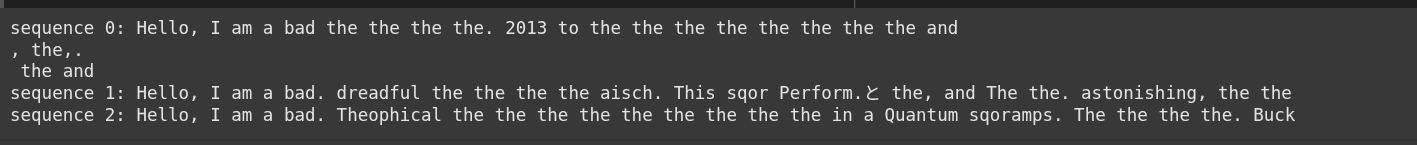